In [1]:
# imports
import pandas as pd
import numpy as np
import sklearn as sk
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn import tree
from sklearn.model_selection import GridSearchCV
#import nbimporter
#from funcs import *
from xgboost import XGBRegressor
import copy

In [2]:
def get_forw(i, winds, plot_fig = False):
    X = np.array(data['series'+str(i)])
    test = X[(n-test_ratio):n]
    
    MSE_dif = 10
    cur_wind = -1
    train_t = -1
    test_t = -1
    regr_res = -1
    
    for wind in winds:
        m=n-wind
        ntest = int((m-test_ratio+1)*cross_test)
        ntrain = (m-test_ratio+1)-ntest
        Xt = np.copy(X[0:wind])
        for i in range(1,m+1):
            Xt =  np.vstack((Xt,X[i:(i+wind)]))
        train_loc = Xt[0:ntrain]
        test_loc = Xt[ntrain:(m-test_ratio+1)]
        regr = linear_model.LinearRegression()
        regr.fit(train_loc[:,0:(wind-1)], train_loc[:,wind-1])
        res_loc = regr.predict(test_loc[:,0:(wind-1)])
        mse_loc = sk.metrics.mean_squared_error(res_loc, test_loc[:,wind-1])
        if (mse_loc < MSE_dif):
            MSE_dif = mse_loc
            cur_wind = wind
            train_t = np.copy(Xt[0:(m-test_ratio+1)])
            test_t = np.copy(Xt[(m-test_ratio+1):(m+1)])
            regr_res = regr

    regr_res.fit(train_t[:,0:(cur_wind-1)], train_t[:,cur_wind-1])
    res_dif = regr_res.predict(test_t[:,0:(cur_wind-1)])
  
    return(np.array([sk.metrics.mean_squared_error(res_dif, test), cur_wind]))

In [3]:
def get_mse(winds, print_msg = True):
    MSE = get_forw(1,winds)
    for i in range(2,101):
        MSE = np.vstack((MSE,get_forw(i,winds)))
        # if (print_msg):
        # print("Linear regression: MSE={}".format(np.round(np.mean(MSE),3)))
    return([np.mean(MSE[:,0]),MSE])

In [39]:
def get_upper_bound(i, plot_fig = False):
    X = np.array(data['series'+str(i)])
    res = X[(n-test_ratio-1):(n-1)]
    test = X[(n-test_ratio):n]
    MSE = sk.metrics.mean_squared_error(res, test)
   
    if (plot_fig):
        plt.plot(res)
        plt.plot(test)
        plt.show()

    return(MSE)

In [40]:
def get_upper_bound_mse(plot_fig = False):
    get_upper_bound(1,plot_fig)
    MSE = []
    for i in range(1,101):
        MSE = np.append(MSE, get_upper_bound(i))
    #print("Linear regression: upper bound MSE={}".format(np.round(np.mean(MSE),3)))
    return(np.mean(MSE))

In [41]:
def get_lower_bound(i, simple=False):
    X = np.array(data['series'+str(i)])
    X_dif = X[1:n]-X[0:(n-1)]
    test_dif = X_dif[(n-test_ratio-1):(n-1)]
    opt = np.var(test_dif)
    opt_wind = 0
    start = n-test_ratio-2 if simple else 1
    for wind in range(start,n-test_ratio-1):
        test_dif = np.copy(X_dif[(n-test_ratio-1):(n-1)])
        for i in range(0,test_ratio):
            test_dif[i] = test_dif[i] - np.mean(X_dif[(n-test_ratio-1 + i-wind):(n-test_ratio-1 + i)])
        tmp = np.var(test_dif)
        if (tmp < opt):
            opt = tmp
            opt_wind = wind

    return([opt,opt_wind])

In [42]:
def get_lower_bound_mse(simple=False):
    MSE = []
    winds = []
    for i in range(1,101):
        tmp = get_lower_bound(i,simple)
        MSE = np.append(MSE, tmp[0])
        winds = np.append(winds, tmp[1])
    #print("Linear regression: lower bound MSE={}".format(np.round(np.mean(MSE),3)))
    return([np.mean(MSE), winds])

In [43]:
def get_bounds(simple=False):
    lower_bound = get_lower_bound_mse(simple)
    print("bounds MSE = ({}, {})".format(*[np.round(lower_bound[0],3),np.round(get_upper_bound_mse(),3)]))
    return(lower_bound[1])

In [51]:
def get_dif(i,winds, meth, plot_fig = False):
    X = np.array(data['series'+str(i)])
    X_dif = X[1:n]-X[0:(n-1)]

    MSE_dif = 10
    cur_wind = -1
    train_t = -1
    test_t = -1
    regr_res = -1
    params = []
    
    for wind in winds:
        #print(wind, end = '  ')
        m=n-wind
        Xt = X_dif[0:wind]
        for i in range(1,m):
            Xt =  np.vstack((Xt,X_dif[i:(i+wind)]))
        train_loc = np.copy(Xt[0:(m-test_ratio)])
        regr = meth(train_loc[:,0:(wind-1)], train_loc[:,wind-1])
        mse_loc = regr[2]
        #sk.metrics.mean_squared_error(regr[0].predict(train_loc[:,0:(wind-1)]), train_loc[:,wind-1]) 
        if (mse_loc < MSE_dif):
            MSE_dif = mse_loc
            cur_wind = wind
            test_t = np.copy(Xt[(m-test_ratio):m])
            regr_res = regr[0]
            params = regr[1]
        
    res_dif = regr_res.predict(test_t[:,0:(cur_wind-1)])
    
    if (plot_fig):
        plt.plot(res_dif+X[(n-test_ratio-1):(n-1)]) # res
        plt.plot(X[(n-test_ratio):n]) # test
        plt.show()
    #for i in range(0,300):
    #    print((res_dif[i]-test_t[i,cur_wind-1])**2)
    return(np.append(np.array([sk.metrics.mean_squared_error(res_dif, test_t[:,cur_wind-1]), 
                               MSE_dif, cur_wind]), params))

In [52]:
def get_dif_mse(winds, meth, n_ser = 101, print_msg = True):
    #print(1)
    #print(end = '  ')
    MSE = get_dif(1, winds, meth)
    #print()
    for i in range(2,n_ser):
        #print(i)
        #print(end = '  ')
        MSE = np.vstack((MSE,get_dif(i, winds, meth)))
        #print()
        # if (print_msg):
        # print("Linear regression by differences: MSE_dif={}".format(np.round(np.mean(MSE),3)))
    return(MSE)

In [54]:
def lin_regr(X, Y, fi=False):
    regr = linear_model.LinearRegression(fit_intercept=fi)
    params = {'n_jobs': [-1]}
    dt_clf = GridSearchCV(regr, params, cv=3, n_jobs=-1, iid=False, 
                          verbose = 0, scoring='neg_mean_squared_error').fit(X, Y)
    return [dt_clf.best_estimator_, 0, -dt_clf.best_score_]

In [55]:
def lin_regr_intercept(X, Y, fi=True):
    regr = linear_model.LinearRegression(fit_intercept=fi)
    params = {'n_jobs': [-1]}
    dt_clf = GridSearchCV(regr, params, cv=3, n_jobs=-1, iid=False, 
                          verbose = 0, scoring='neg_mean_squared_error').fit(X, Y)
    return [dt_clf.best_estimator_, 0, -dt_clf.best_score_]

In [56]:
def lasso(X, Y, fi=False):
    regr = sk.linear_model.LassoCV(verbose=False,n_jobs=-1, cv=3, fit_intercept=fi).fit(X, Y)
    return [regr, regr.alpha_, min(np.mean(regr.mse_path_,1))]

In [57]:
def lasso_intercept(X, Y, fi=True):
    regr = sk.linear_model.LassoCV(verbose=False,n_jobs=-1, cv=3, fit_intercept=fi).fit(X, Y)
    return [regr, regr.alpha_, min(np.mean(regr.mse_path_,1))]

In [58]:
def tree(X, Y):
    regr = sk.tree.DecisionTreeRegressor()
    params = { 'max_depth': range(1,4),
               'max_leaf_nodes': [5,15,25,50] }
    dt_clf = GridSearchCV(regr, params, cv=3, n_jobs=-1, iid=False, verbose = 0, 
                          scoring='neg_mean_squared_error').fit(X, Y)
    return [dt_clf.best_estimator_, np.array([dt_clf.best_params_['max_depth'], 
            dt_clf.best_params_['max_leaf_nodes']]), -dt_clf.best_score_]

In [59]:
def boost(X, Y):
    regr = XGBRegressor(n_jobs=-1)
    params = {
        'n_estimators' : range(20,121,20),
        'max_depth': range(1,4)
    }
    dt_clf = GridSearchCV(regr, params, cv=3, n_jobs=-1, iid=False, verbose = 0
                          , scoring='neg_mean_squared_error').fit(X, Y)
    return [dt_clf.best_estimator_,np.array([dt_clf.best_params_['n_estimators'], 
                                             dt_clf.best_params_['max_depth']]), -dt_clf.best_score_]

# 1 тренд без шума

In [5]:
# data, params
data = pd.read_csv("series1/linear_trend.csv")
n = data.shape[0]
test_perc = 0.3
test_ratio = int(test_perc*n)
cross_test = 0.35

### По предыдущему значению

In [89]:
wn_min_err = []
for i in range(1,101):
    X = np.array(data['series'+str(i)])
    X_dif = X[1:n]-X[0:(n-1)]
    wn_min_err.append(sk.metrics.mean_squared_error(X_dif[(n-test_ratio-1):(n-1)], 
                                    X_dif[(n-test_ratio-2):(n-2)]))
round(np.mean(wn_min_err), 10)

0.0

### Linear regression

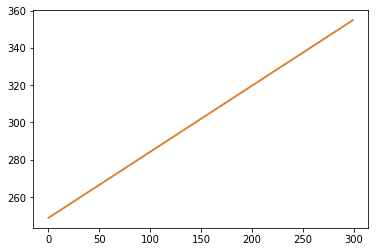

Linear regression: MSE=0.0, train_MSE=0.0, wind=2


In [95]:
res = get_dif(1,[2], lin_regr, True)
print("Linear regression: MSE={}, train_MSE={}, wind={}".format(np.round(res[0],3), np.round(res[1],3), int(res[2])))

In [17]:
regr_wn_mse = get_dif_mse([2], lin_regr) 
print("Linear regression: MSE={}+-{}, train_MSE={}".format(np.round(np.mean(regr_wn_mse[:,0]),3),
    np.round(2*np.var(regr_wn_mse[:,0])**0.5/10,3), np.round(np.mean(regr_wn_mse[:,1]),3)))

Linear regression: MSE=0.0+-0.0, train_MSE=0.0


In [90]:
regr_wn_mse = get_dif_mse([2], lin_regr_intercept) 
print("Linear regression with intercept: MSE={}+-{}, train_MSE={}".format(np.round(np.mean(regr_wn_mse[:,0]),3),
    np.round(2*np.var(regr_wn_mse[:,0])**0.5/10,3), np.round(np.mean(regr_wn_mse[:,1]),3)))

Linear regression with intercept: MSE=0.0+-0.0, train_MSE=0.0


### Lasso

In [92]:
regr_wn_mse = get_dif_mse([2], lasso) 
print("Lasso: MSE={}+-{}, train_MSE={}, mean_alpha={}".format(np.round(np.mean(regr_wn_mse[:,0]),3),
    np.round(2*np.var(regr_wn_mse[:,0])**0.5/10,3), np.round(np.mean(regr_wn_mse[:,1]),3),
    np.round(np.mean(regr_wn_mse[:,3]),3)))

Lasso: MSE=0.0+-0.0, train_MSE=0.0, mean_alpha=0.0


In [93]:
regr_wn_mse = get_dif_mse([2], lasso_intercept) 
print("Lasso with intercept: MSE={}+-{}, train_MSE={}".format(np.round(np.mean(regr_wn_mse[:,0]),3),
    np.round(2*np.var(regr_wn_mse[:,0])**0.5/10,3), np.round(np.mean(regr_wn_mse[:,1]),3),
    np.round(np.mean(regr_wn_mse[:,3]),3)))

Lasso with intercept: MSE=0.0+-0.0, train_MSE=0.0


### Tree

In [97]:
regr_wn_mse = get_dif_mse([2], tree) 
print("Tree: MSE={}+-{}, train_MSE={}, depth={}, max_leaf={}".format(np.round(np.mean(regr_wn_mse[:,0]),3),
    np.round(2*np.var(regr_wn_mse[:,0])**0.5/10,3), np.round(np.mean(regr_wn_mse[:,1]),3),
    np.round(np.mean(regr_wn_mse[:,3]),3), np.round(np.mean(regr_wn_mse[:,4]),3)))

Tree: MSE=0.0+-0.0, train_MSE=0.0, depth=1.0, max_leaf=5.0


### XGBoost

In [99]:
regr_wn_mse = get_dif_mse([2], tree) 
print("Linear regression: MSE={}+-{}, train_MSE={}, estim={}, depth={}".format(np.round(np.mean(regr_wn_mse[:,0]),3),
    np.round(2*np.var(regr_wn_mse[:,0])**0.5/10,3), np.round(np.mean(regr_wn_mse[:,1]),3),
    np.round(np.mean(regr_wn_mse[:,3]),3), np.round(np.mean(regr_wn_mse[:,4]),3)))

Linear regression: MSE=0.0+-0.0, train_MSE=0.0, estim=1.0, depth=5.0


# Броуновское движение

In [115]:
data = pd.read_csv("series1/white_noise.csv")

arr_name = []
arr_train = []
arr_test = []
arr_var = []

### ошибка по предыдущему значению

In [109]:
wn_min_err = []
for i in range(1,101):
    wn_min_err.append(round(sk.metrics.mean_squared_error(data['series'+str(i)][(n-test_ratio):n], 
                                    data['series'+str(i)][(n-test_ratio-1):(n-1)]), 3))
np.mean(wn_min_err)

1.01068

### ошибка по предсказанию нулями для разностей

In [111]:
wn_min_err = []
for i in range(1,101):
    X = np.array(data['series'+str(i)])
    X_dif = X[1:n]-X[0:(n-1)]
    wn_min_err.append(sk.metrics.mean_squared_error(X_dif[(n-test_ratio-1):(n-1)], np.zeros(test_ratio)))
np.mean(wn_min_err)

1.0106999202433393

### окна

In [113]:
winds = [2,4,8,12,16,20]

### Linear regression

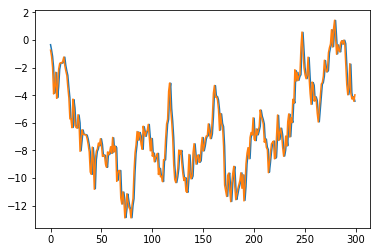

In [114]:
res = get_dif(1,winds, lin_regr, True)

In [116]:
regr_wn_mse = get_dif_mse(winds, lin_regr)

In [117]:
print("Linear regression: MSE={}+-{}, train_MSE={}".format(np.round(np.mean(regr_wn_mse[:,0]),3),
    np.round(2*np.var(regr_wn_mse[:,0])**0.5/10,3), np.round(np.mean(regr_wn_mse[:,1]),3)))

Linear regression: MSE=1.015+-0.018, train_MSE=0.991


In [118]:
regr_i_wn_mse = get_dif_mse(winds, lin_regr_intercept)

In [119]:
print("Linear regression with intercept: MSE={}+-{}, train_MSE={}".format(
    np.round(np.mean(regr_i_wn_mse[:,0]),3), np.round(2*np.var(regr_i_wn_mse[:,0])**0.5/10,3), 
    np.round(np.mean(regr_i_wn_mse[:,1]),3)))

Linear regression with intercept: MSE=1.017+-0.018, train_MSE=0.993


In [120]:
arr_name.append('Lin regr')
arr_train.append(np.round(np.mean(regr_wn_mse[:,1]),3))
arr_test.append(np.round(np.mean(regr_wn_mse[:,0]),3))
arr_var.append(np.round(2*np.var(regr_wn_mse[:,0])**0.5/10,3))

arr_name.append('Lin regr with intercept')
arr_train.append(np.round(np.mean(regr_i_wn_mse[:,1]),3))
arr_test.append(np.round(np.mean(regr_i_wn_mse[:,0]),3))
arr_var.append(np.round(2*np.var(regr_i_wn_mse[:,0])**0.5/10,3))

### Lasso

In [122]:
lasso_wn_mse = get_dif_mse(winds, lasso)

In [126]:
print("Linear regression: MSE={}+-{}, train_MSE={}, wind={}, mean_alpha={}".format(
    np.round(np.mean(lasso_wn_mse[:,0]),3), np.round(2*np.var(lasso_wn_mse[:,0])**0.5/10,3),
    np.round(np.mean(lasso_wn_mse[:,1]),3), np.round(np.mean(lasso_wn_mse[:,2]),3),
    np.round(np.mean(lasso_wn_mse[:,3]),3)))

Linear regression: MSE=1.012+-0.018, train_MSE=0.985, wind=10.54, mean_alpha=0.048


In [124]:
lasso_i_wn_mse = get_dif_mse(winds, lasso_intercept)

In [125]:
print("Linear regression: MSE={}+-{}, train_MSE={}, wind={}, mean_alpha={}".format(
    np.round(np.mean(lasso_i_wn_mse[:,0]),3), np.round(2*np.var(lasso_i_wn_mse[:,0])**0.5/10,3),
    np.round(np.mean(lasso_i_wn_mse[:,1]),3), np.round(np.mean(lasso_i_wn_mse[:,2]),3),
    np.round(np.mean(lasso_i_wn_mse[:,3]),3)))

Linear regression: MSE=1.014+-0.018, train_MSE=0.986, wind=10.72, mean_alpha=0.049


In [127]:
arr_name.append('Lasso')
arr_train.append(np.round(np.mean(lasso_wn_mse[:,1]),3))
arr_test.append(np.round(np.mean(lasso_wn_mse[:,0]),3))
arr_var.append(np.round(2*np.var(lasso_wn_mse[:,0])**0.5/10,3))

arr_name.append('Lasso with intercept')
arr_train.append(np.round(np.mean(lasso_i_wn_mse[:,1]),3))
arr_test.append(np.round(np.mean(lasso_i_wn_mse[:,0]),3))
arr_var.append(np.round(2*np.var(lasso_i_wn_mse[:,0])**0.5/10,3))

### Tree

In [128]:
tree_wn_mse = get_dif_mse(winds, tree)

In [129]:
print("Tree: MSE={}+-{}, train_MSE={}, wind={}, depth={}, max_leaf={}".format(
    np.round(np.mean(tree_wn_mse[:,0]),3), np.round(2*np.var(tree_wn_mse[:,0])**0.5/10,3), 
    np.round(np.mean(tree_wn_mse[:,1]),3), np.round(np.mean(tree_wn_mse[:,2]),3), 
    np.round(np.mean(tree_wn_mse[:,3]),3), np.round(np.mean(tree_wn_mse[:,4]),3)))

Tree: MSE=1.048+-0.02, train_MSE=1.01, wind=6.26, depth=1.17, max_leaf=8.35


In [130]:
arr_name.append('Tree')
arr_train.append(np.round(np.mean(tree_wn_mse[:,1]),3))
arr_test.append(np.round(np.mean(tree_wn_mse[:,0]),3))
arr_var.append(np.round(2*np.var(tree_wn_mse[:,0])**0.5/10,3))

### XGBoost

In [131]:
boost_wn_mse = get_dif_mse(winds, boost)

In [132]:
print("Boost: MSE={}+-{}, train_MSE={}, wind={}, n_estim={}, depth={}".format(
    np.round(np.mean(boost_wn_mse[:,0]),3), np.round(2*np.var(boost_wn_mse[:,0])**0.5/10,3), 
    np.round(np.mean(boost_wn_mse[:,1]),3), np.round(np.mean(boost_wn_mse[:,2]),3),
    np.round(np.mean(boost_wn_mse[:,3]),3), np.round(np.mean(boost_wn_mse[:,4]),3)))

Boost: MSE=1.024+-0.019, train_MSE=0.991, wind=8.22, n_estim=31.2, depth=1.09


In [133]:
arr_name.append('XGBoost')
arr_train.append(np.round(np.mean(boost_wn_mse[:,1]),3))
arr_test.append(np.round(np.mean(boost_wn_mse[:,0]),3))
arr_var.append(np.round(2*np.var(boost_wn_mse[:,0])**0.5/10,3))

### Результаты

In [134]:
dic={'name':arr_name, 'train': arr_train, 'test': arr_test, 'conf int': arr_var}
df=pd.DataFrame(data=dic)
df

,name,train,test,conf int
0,Lin regr,0.991,1.015,0.018
1,Lin regr with intercept,0.993,1.017,0.018
2,Lasso,0.985,1.012,0.018
3,Lasso with intercept,0.986,1.014,0.018
4,Tree,1.010,1.048,0.020
5,XGBoost,0.991,1.024,0.019


# Простой тренд + Броуновское движение

In [72]:
data = pd.read_csv("series1/trend_whiteNoise.csv")

arr_name = []
arr_train = []
arr_test = []
arr_var = []

### Лучший и худший случаи
##### Худший - по предыдущему, теорерическая ошибка $1.25 = \sigma^2 + \sigma_a^2$, $\lambda =200$
##### Лучший - из предыдущей разности вычитать среднее по всем предыдущим элементам. Теоретически равна $1 = \sigma^2$

In [46]:
lower_bounds_winds = get_bounds(True)

bounds MSE = (1.007, 1.221)


### окна

In [49]:
winds = [2,4,8,12,16,20]

### Linear regression

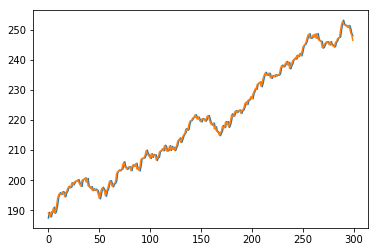

In [67]:
res = get_dif(1,winds, lin_regr, True)

In [73]:
regr_wn_mse = get_dif_mse(winds, lin_regr)

In [74]:
print("Linear regression: MSE={}+-{}, train_MSE={}".format(np.round(np.mean(regr_wn_mse[:,0]),3),
    np.round(2*np.var(regr_wn_mse[:,0])**0.5/10,3), np.round(np.mean(regr_wn_mse[:,1]),3)))

Linear regression: MSE=1.063+-0.018, train_MSE=1.051


In [75]:
regr_i_wn_mse = get_dif_mse(winds, lin_regr_intercept)

In [76]:
print("Linear regression with intercept: MSE={}+-{}, train_MSE={}".format(
    np.round(np.mean(regr_i_wn_mse[:,0]),3), np.round(2*np.var(regr_i_wn_mse[:,0])**0.5/10,3), 
    np.round(np.mean(regr_i_wn_mse[:,1]),3)))

Linear regression with intercept: MSE=1.015+-0.018, train_MSE=1.006


In [77]:
arr_name.append('Lin regr')
arr_train.append(np.round(np.mean(regr_wn_mse[:,1]),3))
arr_test.append(np.round(np.mean(regr_wn_mse[:,0]),3))
arr_var.append(np.round(2*np.var(regr_wn_mse[:,0])**0.5/10,3))

arr_name.append('Lin regr with intercept')
arr_train.append(np.round(np.mean(regr_i_wn_mse[:,1]),3))
arr_test.append(np.round(np.mean(regr_i_wn_mse[:,0]),3))
arr_var.append(np.round(2*np.var(regr_i_wn_mse[:,0])**0.5/10,3))

### Lasso

In [78]:
lasso_wn_mse = get_dif_mse(winds, lasso)

In [86]:
print("Lasso: MSE={}+-{}, train_MSE={}, wind={}, mean_alpha={}".format(
    np.round(np.mean(lasso_wn_mse[:,0]),3), np.round(2*np.var(lasso_wn_mse[:,0])**0.5/10,3),
    np.round(np.mean(lasso_wn_mse[:,1]),3), np.round(np.mean(lasso_wn_mse[:,2]),3),
    np.round(np.mean(lasso_wn_mse[:,3]),3)))

Lasso: MSE=1.056+-0.018, train_MSE=1.044, wind=14.52, mean_alpha=0.035


In [80]:
lasso_i_wn_mse = get_dif_mse(winds, lasso_intercept)

In [87]:
print("Lasso with intercept: MSE={}+-{}, train_MSE={}, wind={}, mean_alpha={}".format(
    np.round(np.mean(lasso_i_wn_mse[:,0]),3), np.round(2*np.var(lasso_i_wn_mse[:,0])**0.5/10,3),
    np.round(np.mean(lasso_i_wn_mse[:,1]),3), np.round(np.mean(lasso_i_wn_mse[:,2]),3),
    np.round(np.mean(lasso_i_wn_mse[:,3]),3)))

Lasso with intercept: MSE=1.012+-0.018, train_MSE=1.0, wind=10.18, mean_alpha=0.049


In [82]:
arr_name.append('Lasso')
arr_train.append(np.round(np.mean(lasso_wn_mse[:,1]),3))
arr_test.append(np.round(np.mean(lasso_wn_mse[:,0]),3))
arr_var.append(np.round(2*np.var(lasso_wn_mse[:,0])**0.5/10,3))

arr_name.append('Lasso with intercept')
arr_train.append(np.round(np.mean(lasso_i_wn_mse[:,1]),3))
arr_test.append(np.round(np.mean(lasso_i_wn_mse[:,0]),3))
arr_var.append(np.round(2*np.var(lasso_i_wn_mse[:,0])**0.5/10,3))

### Tree

In [83]:
tree_wn_mse = get_dif_mse(winds, tree)

In [84]:
print("Tree: MSE={}+-{}, train_MSE={}, wind={}, depth={}, max_leaf={}".format(
    np.round(np.mean(tree_wn_mse[:,0]),3), np.round(2*np.var(tree_wn_mse[:,0])**0.5/10,3), 
    np.round(np.mean(tree_wn_mse[:,1]),3), np.round(np.mean(tree_wn_mse[:,2]),3), 
    np.round(np.mean(tree_wn_mse[:,3]),3), np.round(np.mean(tree_wn_mse[:,4]),3)))

Tree: MSE=1.043+-0.019, train_MSE=1.027, wind=6.3, depth=1.14, max_leaf=7.75


In [85]:
arr_name.append('Tree')
arr_train.append(np.round(np.mean(tree_wn_mse[:,1]),3))
arr_test.append(np.round(np.mean(tree_wn_mse[:,0]),3))
arr_var.append(np.round(2*np.var(tree_wn_mse[:,0])**0.5/10,3))

### XGBoost

In [89]:
boost_wn_mse = get_dif_mse(winds, boost)

In [90]:
print("Boost: MSE={}+-{}, train_MSE={}, wind={}, n_estim={}, depth={}".format(
    np.round(np.mean(boost_wn_mse[:,0]),3), np.round(2*np.var(boost_wn_mse[:,0])**0.5/10,3), 
    np.round(np.mean(boost_wn_mse[:,1]),3), np.round(np.mean(boost_wn_mse[:,2]),3),
    np.round(np.mean(boost_wn_mse[:,3]),3), np.round(np.mean(boost_wn_mse[:,4]),3)))

Boost: MSE=1.022+-0.018, train_MSE=1.005, wind=9.3, n_estim=35.2, depth=1.04


In [91]:
arr_name.append('XGBoost')
arr_train.append(np.round(np.mean(boost_wn_mse[:,1]),3))
arr_test.append(np.round(np.mean(boost_wn_mse[:,0]),3))
arr_var.append(np.round(2*np.var(boost_wn_mse[:,0])**0.5/10,3))

### Результаты

In [92]:
dic={'name':arr_name, 'train': arr_train, 'test': arr_test, 'conf int': arr_var}
df=pd.DataFrame(data=dic)
df

,name,train,test,conf int
0,Lin regr,1.051,1.063,0.018
1,Lin regr with intercept,1.006,1.015,0.018
2,Lasso,1.044,1.056,0.018
3,Lasso with intercept,1.000,1.012,0.018
4,Tree,1.027,1.043,0.019
5,XGBoost,1.005,1.022,0.018


# Несколько трендов без шума

In [93]:
data = pd.read_csv("series1/difficult_trend.csv")

arr_name = []
arr_train = []
arr_test = []
arr_var = []

### Теоретическая минимальная ошибка
##### $2\sigma^2\lambda=2*0.25/200=0.0025$

### по предыдущему значению

In [94]:
wn_min_err = []
for i in range(1,101):
    X = np.array(data['series'+str(i)])
    X_dif = X[1:n]-X[0:(n-1)]
    wn_min_err.append(sk.metrics.mean_squared_error(X_dif[(n-test_ratio-1):(n-1)], 
                                    X_dif[(n-test_ratio-2):(n-2)]))
np.mean(wn_min_err)

0.002258664134147905

### Linear regression

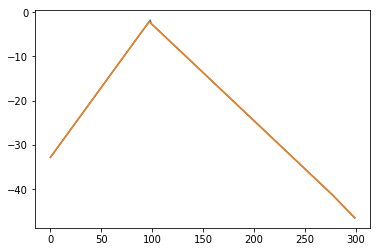

Linear regression: MSE=0.001, train_MSE=0.001, wind=2


In [97]:
res = get_dif(2, [2], lin_regr, True)
print("Linear regression: MSE={}, train_MSE={}, wind={}".format(np.round(res[0],3), np.round(res[1],3), 
    int(res[2])))

In [108]:
regr_wn_mse = get_dif_mse([2], lin_regr)

In [109]:
print("Linear regression: MSE={}+-{}, train_MSE={}".format(np.round(np.mean(regr_wn_mse[:,0]),3),
    np.round(2*np.var(regr_wn_mse[:,0])**.5/10,3), np.round(np.mean(regr_wn_mse[:,1]),3)))

Linear regression: MSE=0.002+-0.001, train_MSE=0.003


In [110]:
regr_i_wn_mse = get_dif_mse([2], lin_regr_intercept)

In [111]:
print("Linear regression: MSE={}+-{}, train_MSE={}".format(np.round(np.mean(regr_i_wn_mse[:,0]),3),
    np.round(2*np.var(regr_i_wn_mse[:,0])**.5/10,3), np.round(np.mean(regr_i_wn_mse[:,1]),3)))

Linear regression: MSE=0.002+-0.001, train_MSE=0.056


In [112]:
arr_name.append('Lin regr')
arr_train.append(np.round(np.mean(regr_wn_mse[:,1]),3))
arr_test.append(np.round(np.mean(regr_wn_mse[:,0]),3))
arr_var.append(np.round(2*np.var(regr_wn_mse[:,0])**.5/10,3))

arr_name.append('Lin regr with intercept')
arr_train.append(np.round(np.mean(regr_i_wn_mse[:,1]),3))
arr_test.append(np.round(np.mean(regr_i_wn_mse[:,0]),3))
arr_var.append(np.round(2*np.var(regr_i_wn_mse[:,0])**.5/10,3))

### Lasso

In [115]:
lasso_wn_mse = get_dif_mse([2], lasso)

In [118]:
print("Lasso: MSE={}+-{}, train_MSE={}, mean_alpha={}".format(
    np.round(np.mean(lasso_wn_mse[:,0]),3), np.round(2*np.var(lasso_wn_mse[:,0])**.5/10,3),
    np.round(np.mean(lasso_wn_mse[:,1]),3), np.round(np.mean(lasso_wn_mse[:,3]),3)))

Lasso: MSE=0.002+-0.001, train_MSE=0.003, mean_alpha=0.0


In [117]:
lasso_i_wn_mse = get_dif_mse([2], lasso_intercept)

In [119]:
print("Lasso with intercept: MSE={}+-{}, train_MSE={}, mean_alpha={}".format(
    np.round(np.mean(lasso_i_wn_mse[:,0]),3), np.round(2*np.var(lasso_i_wn_mse[:,0])**.5/10,3),
    np.round(np.mean(lasso_i_wn_mse[:,1]),3), np.round(np.mean(lasso_i_wn_mse[:,3]),3)))

Lasso with intercept: MSE=0.002+-0.001, train_MSE=0.026, mean_alpha=0.0


In [120]:
arr_name.append('Lasso')
arr_train.append(np.round(np.mean(lasso_wn_mse[:,1]),3))
arr_test.append(np.round(np.mean(lasso_wn_mse[:,0]),3))
arr_var.append(np.round(2*np.var(lasso_wn_mse[:,0])**.5/10,3))

arr_name.append('Lasso with intercept')
arr_train.append(np.round(np.mean(lasso_i_wn_mse[:,1]),3))
arr_test.append(np.round(np.mean(lasso_i_wn_mse[:,0]),3))
arr_var.append(np.round(2*np.var(lasso_i_wn_mse[:,0])**.5/10,3))

### Tree

In [122]:
tree_wn_mse = get_dif_mse([2], tree)

In [123]:
print("Tree: MSE={}+-{}, train_MSE={}, depth={}, max_leaf={}".format(np.round(np.mean(tree_wn_mse[:,0]),3), 
    np.round(2*np.var(tree_wn_mse[:,0])**.5/10,3), np.round(np.mean(tree_wn_mse[:,1]),3), 
    np.round(np.mean(tree_wn_mse[:,3]),3), np.round(np.mean(tree_wn_mse[:,4]),3)))

Tree: MSE=0.057+-0.034, train_MSE=0.061, depth=1.57, max_leaf=5.9


In [124]:
arr_name.append('Tree')
arr_train.append(np.round(np.mean(tree_wn_mse[:,1]),3))
arr_test.append(np.round(np.mean(tree_wn_mse[:,0]),3))
arr_var.append(np.round(2*np.var(tree_wn_mse[:,0])**.5/10,3))

### XGBoost

In [125]:
boost_wn_mse = get_dif_mse([2], boost)

In [126]:
print("Tree: MSE={}+-{}, train_MSE={}, mean_estim={}, mean_depth={}".format(np.round(np.mean(boost_wn_mse[:,0]),3), 
    np.round(2*np.var(boost_wn_mse[:,0])**.5/10,3), np.round(np.mean(boost_wn_mse[:,1]),3), 
    np.round(np.mean(boost_wn_mse[:,3]),3), np.round(np.mean(boost_wn_mse[:,4]),3)))

Tree: MSE=0.056+-0.034, train_MSE=0.056, mean_estim=71.2, mean_depth=1.96


In [127]:
arr_name.append('XGBoost')
arr_train.append(np.round(np.mean(boost_wn_mse[:,1]),3))
arr_test.append(np.round(np.mean(boost_wn_mse[:,0]),3))
arr_var.append(np.round(2*np.var(boost_wn_mse[:,0])**.5/10,3))

### Результаты

In [128]:
dic={'name':arr_name, 'train': arr_train, 'test': arr_test, 'conf int': arr_var}
df=pd.DataFrame(data=dic)
df

,name,train,test,conf int
0,Lin regr,0.003,0.002,0.001
1,Lin regr,0.003,0.002,0.001
2,Lin regr with intercept,0.056,0.002,0.001
3,Lasso,0.003,0.002,0.001
4,Lasso with intercept,0.026,0.002,0.001
5,Tree,0.061,0.057,0.034
6,XGBoost,0.056,0.056,0.034


# Несколько трендов с шумом, sd шума = 1, sd угла наклона = 0.25

In [13]:
# google colab
from google.colab import files

uploaded = files.upload()

Saving difficultTrend_whiteNoise.csv to difficultTrend_whiteNoise.csv


In [147]:
# data
data = pd.read_csv("series1/difficultTrend_whiteNoise.csv")
n = data.shape[0]
test_perc = 0.3
test_ratio = int(test_perc*n)

arr_name = []
arr_train = []
arr_test = []
arr_var= []

### Лучший и худший случаи
##### Худший - по предыдущему, теорерическая ошибка $1.2525 = \sigma^2 + \sigma_a^2 + 2\sigma_a^2/\lambda$, $\lambda =200$
##### Лучший - из предыдущего вычитать среднее, посчитанное по последним n элементам, n подбирается кроссвалидацией. Теоретически равна $1.0025 = \sigma^2 + 2\sigma_a^2/\lambda$, $\lambda =200$

In [68]:
lower_bounds_winds = get_bounds()

bounds MSE = (1.027, 1.258)


##### длина окна для каждого ряда и средняя длина окна

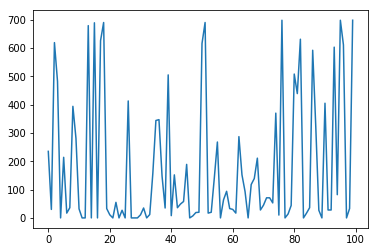

178.48

In [69]:
plt.plot(lower_bounds_winds)
plt.show()
np.mean(lower_bounds_winds)

### Линейная регрессия не на разностях

In [130]:
winds = np.array(range(2,20,1))
winds = np.append(winds, np.array(range(20,120,5)))
winds

array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  25,  30,  35,  40,  45,  50,  55,
        60,  65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115])

In [0]:
regr_mse = get_mse(winds)

##### ошибка

In [0]:
regr_mse[0]

1.1914692332405425

### Линейная регрессия на разностях

In [131]:
winds = np.array(range(2,20,1))
winds = np.append(winds, np.array(range(20,120,5)))

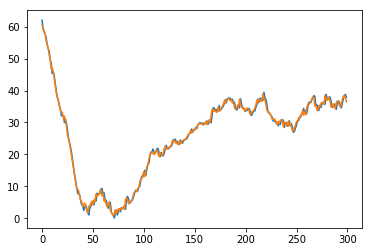

In [139]:
res = get_dif(7,winds, lin_regr, True)

In [140]:
regr_dif_mse = get_dif_mse(winds, lin_regr)

In [141]:
print("Linear regression: MSE={}+-{}, train_MSE={}, mean_wind={}".format(
    np.round(np.mean(regr_dif_mse[:,0]),3), np.round(2*np.var(regr_dif_mse[:,0])**.5/10,3),
    np.round(np.mean(regr_dif_mse[:,1]),3), np.mean(regr_dif_mse[:,2])))

Linear regression: MSE=1.091+-0.023, train_MSE=1.085, mean_wind=15.42


In [142]:
regr_i_dif_mse = get_dif_mse(winds, lin_regr_intercept)

In [143]:
print("Linear regression with intercept: MSE={}+-{}, train_MSE={}, mean_wind={}".format(
    np.round(np.mean(regr_i_dif_mse[:,0]),3), np.round(2*np.var(regr_i_dif_mse[:,0])**.5/10,3),
    np.round(np.mean(regr_i_dif_mse[:,1]),3), np.mean(regr_i_dif_mse[:,2])))

Linear regression with intercept: MSE=1.15+-0.142, train_MSE=1.112, mean_wind=12.81


In [148]:
arr_name.append('Lin regr')
arr_train.append(np.round(np.mean(regr_dif_mse[:,1]),3))
arr_test.append(np.round(np.mean(regr_dif_mse[:,0]),3))
arr_var.append(np.round(2*np.var(regr_i_dif_mse[:,0])**.5/10,3))

arr_name.append('Lin regr with intercept')
arr_train.append(np.round(np.mean(regr_i_dif_mse[:,1]),3))
arr_test.append(np.round(np.mean(regr_i_dif_mse[:,0]),3))
arr_var.append(np.round(2*np.var(regr_i_dif_mse[:,0])**.5/10,3))

### Lasso  на разностях

In [145]:
lasso_dif_mse = get_dif_mse(winds, lasso)

In [146]:
print("Lasso: MSE={}+-{}, train_MSE={}, mean_wind={}, mean_alpha={}".format(
    np.round(np.mean(lasso_dif_mse[:,0]),3), np.round(2*np.var(lasso_dif_mse[:,0])**.5/10,3),
    np.round(np.mean(lasso_dif_mse[:,1]),3), np.mean(lasso_dif_mse[:,2]), 
    np.round(np.mean(lasso_dif_mse[:,3]), 3)))

Lasso: MSE=1.09+-0.02, train_MSE=1.062, mean_wind=52.78, mean_alpha=0.048


In [150]:
lasso_i_dif_mse = get_dif_mse(winds, lasso_intercept)

In [151]:
print("Lasso with intercepr: MSE={}+-{}, train_MSE={}, mean_wind={}, mean_alpha={}".format(
    np.round(np.mean(lasso_i_dif_mse[:,0]),3), np.round(2*np.var(lasso_i_dif_mse[:,0])**.5/10,3),
    np.round(np.mean(lasso_i_dif_mse[:,1]),3), np.mean(lasso_i_dif_mse[:,2]), 
    np.round(np.mean(lasso_i_dif_mse[:,3]), 3)))

Lasso with intercepr: MSE=1.149+-0.049, train_MSE=1.083, mean_wind=50.05, mean_alpha=0.046


In [152]:
arr_name.append('Lasso')
arr_train.append(np.round(np.mean(lasso_dif_mse[:,1]),3))
arr_test.append(np.round(np.mean(lasso_dif_mse[:,0]),3))
arr_var.append(np.round(2*np.var(lasso_dif_mse[:,0])**.5/10,3))

arr_name.append('Lasso with intercept')
arr_train.append(np.round(np.mean(lasso_i_dif_mse[:,1]),3))
arr_test.append(np.round(np.mean(lasso_i_dif_mse[:,0]),3))
arr_var.append(np.round(2*np.var(lasso_i_dif_mse[:,0])**.5/10,3))

### Tree  на разностях

In [153]:
tree_dif_mse = get_dif_mse(winds, tree)

In [154]:
print("Tree: MSE={}+-{}, train_MSE={}, mean_wind={}, depth={}, max_leaf={}".format(
    np.round(np.mean(tree_dif_mse[:,0]),3), np.round(2*np.var(tree_dif_mse[:,0])**.5/10,3),
    np.round(np.mean(tree_dif_mse[:,1]),3), np.mean(tree_dif_mse[:,2]), 
    np.round(np.mean(tree_dif_mse[:,3]), 3), np.round(np.mean(tree_dif_mse[:,4]), 3)))

Tree: MSE=1.291+-0.064, train_MSE=1.171, mean_wind=30.97, depth=1.45, max_leaf=10.45


In [155]:
arr_name.append('Tree')
arr_train.append(np.round(np.mean(tree_dif_mse[:,1]),3))
arr_test.append(np.round(np.mean(tree_dif_mse[:,0]),3))
arr_var.append(np.round(2*np.var(tree_dif_mse[:,0])**.5/10,3))

### Boosting  на разностях

In [156]:
winds_boost = np.array(range(2,20,3))
winds_boost = np.append(winds_boost, np.array(range(20,141,15)))

In [157]:
boost_dif_mse = get_dif_mse(winds_boost, boost)

In [158]:
print("Tree: MSE={}+-{}, train_MSE={}, mean_wind={}, mean_estim={}, mean_depth={}".format(
    np.round(np.mean(boost_dif_mse[:,0]),3), np.round(2*np.var(boost_dif_mse[:,0])**.5/10,3),
    np.round(np.mean(boost_dif_mse[:,1]),3), np.mean(boost_dif_mse[:,2]), 
    np.round(np.mean(boost_dif_mse[:,3]), 3), np.round(np.mean(boost_dif_mse[:,4]), 3)))

Tree: MSE=1.181+-0.046, train_MSE=1.099, mean_wind=58.91, mean_estim=42.6, mean_depth=1.5


In [159]:
arr_name.append('XGBoost')
arr_train.append(np.round(np.mean(boost_dif_mse[:,1]),3))
arr_test.append(np.round(np.mean(boost_dif_mse[:,0]),3))
arr_var.append(np.round(np.var(boost_dif_mse[:,0])**.5/10,3))

### Результаты

In [160]:
dic={'name':arr_name, 'train': arr_train, 'test': arr_test, 'var': arr_var}
df=pd.DataFrame(data=dic)
df

,name,train,test,var
0,Lin regr,1.085,1.091,0.053
1,Lin regr with intercept,1.112,1.150,0.053
2,Lasso,1.062,1.090,0.020
3,Lasso with intercept,1.083,1.149,0.049
4,Tree,1.171,1.291,0.064
5,XGBoost,1.099,1.181,0.023
